# Word embedding layer in Keras for Twitter US Airline Sentiment Classification

#### The embedding layer in keras can learn the word embeddings for our corpus which can then used for classification

In [33]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("dark_background")
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Reading Preprocessed data

In [34]:
twDF = pd.read_csv("Dataset/tweets_preprocessed.csv").drop(['Unnamed: 0'],axis=1)
twDF.head()

,tweet_id,airline_sentiment,negativereason,airline,text_clean
0,570306133677760513,0,NaN,Virgin America,dhepburn said
1,570301130888122368,0,NaN,Virgin America,plus added commercials experience tacky
2,570301083672813571,0,NaN,Virgin America,not today must mean need take another trip
3,570301031407624196,1,Bad Flight,Virgin America,really aggressive blast obnoxious entertainmen...
4,570300817074462722,1,Can't Tell,Virgin America,really big bad thing


In [35]:
corpus = twDF['text_clean'].tolist()

In [36]:
# list of sentences for further processsing
corpus[:5]

['dhepburn said',
 'plus added commercials experience tacky',
 'not today must mean need take another trip',
 'really aggressive blast obnoxious entertainment guests faces amp little recourse',
 'really big bad thing']

### Removing less frequent words

In [37]:
#https://stackoverflow.com/questions/57179045/how-to-remove-less-frequent-words-from-pandas-dataframe/57179318
all_ = [x for y in corpus for x in y.split(' ') ]
a,b = np.unique(all_, return_counts = True)
to_remove = a[b<3]
corpus = [' '.join(np.array(y.split(' '))[~np.isin(y.split(' '), to_remove)]) for y in corpus]

In [38]:
target = twDF['airline_sentiment'].values

In [39]:
all_ = [x for y in docs for x in y.split(' ') ]
a,b = np.unique(all_, return_counts = True)
print("number of unique words in corpus are",len(a))

number of unique words in corpus are 4442


In [40]:
max_length = len(max(docs, key = len).split(" "))
max_length

20

**Notes:**

1.max_length is the length of longest sentence in our corpus after removing less frequent words

In [41]:
# encoding our corpus
input_len = len(a)*5
corp_enc = [one_hot(d, input_len) for d in corpus]

In [42]:
print(corp_enc[:10])

[[11196], [16612, 8874, 5045, 12015], [15993, 10173, 8192, 9244, 8845, 3938, 408, 7877], [17565, 15040, 14892, 3651, 7618, 6124, 14442, 19087], [17565, 2613, 8994, 9463], [14119, 21073, 3899, 13830, 15976, 15642, 15993, 20029, 17565, 8994, 9463, 2973, 14056], [17525, 282, 13549, 145, 19267, 8762, 2678, 12453], [17565, 12780, 9217, 10181, 17759, 4860, 7196, 4494, 17253], [12163, 20340, 15993], [3297, 15516, 8195, 9776, 3312]]


In [43]:
# pad documents to a max length of 4 words
corp_pad = pad_sequences(corp_enc, maxlen=max_length, padding='post')
print(corp_pad)

[[11196     0     0 ...     0     0     0]
 [16612  8874  5045 ...     0     0     0]
 [15993 10173  8192 ...     0     0     0]
 ...
 [19736 18698 20245 ...     0     0     0]
 [14412   798 15976 ...     0     0     0]
 [16042 16539  8845 ...     0     0     0]]


**Notes:**

1.one_hot converts each word into integer encoding (sequences)

2.pad_sequences pads the sequences with zeros

## Modeling with keras embedding layer

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(corp_pad, target, test_size=0.33, random_state=42, stratify=target)

In [53]:
# define the model
import keras
from keras.layers import Dropout
vector_size = 200
opt = keras.optimizers.Adam(learning_rate=0.0001)
model = Sequential()
model.add(Embedding(input_len, vector_size, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[keras.metrics.Recall()])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 200)           4442000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 4001      
Total params: 4,446,001
Trainable params: 4,446,001
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
# fitting model
result=model.fit(X_train, y_train,validation_split=0.33, epochs=6,verbose=0,batch_size=64)

In [55]:
# model evaluation
loss, recall = model.evaluate(X_test, y_test, verbose=0)
print('recall:',recall)

recall: 0.865026593208313


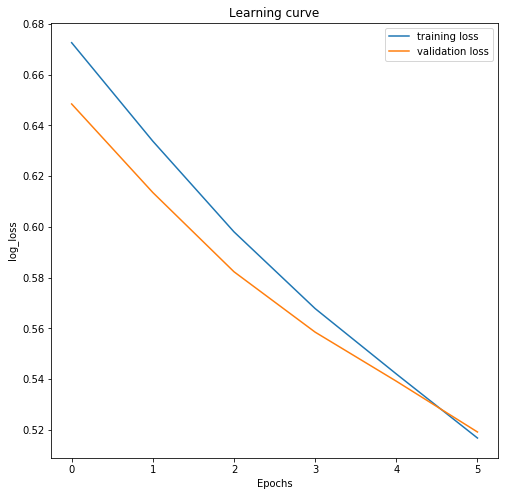

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(result.history["loss"], label="training loss")
plt.plot(result.history["val_loss"], label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### A recall of 0.865 is obtained